<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/u2net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install -Uq torchinfo albumentations

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import io
import os
import math
import time
import random
import requests
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as tfms
import torchvision.models as models
import tensorflow as tf
import moviepy.editor as mvp
import albumentations as A
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.utils import make_grid
from torchinfo import summary
from fastprogress.fastprogress import progress_bar
from matplotlib.gridspec import GridSpec
from IPython.display import Image, HTML, clear_output
from moviepy.editor import VideoClip

os.environ['FFMPEG_BINARY'] = 'ffmpeg'

sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
print("albumentations: {}".format(A.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

Infos:
numpy: 1.19.5
seaborn: 0.11.1
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
albumentations: 0.1.12
cuda device #0: Tesla T4
current device type: cuda


## Utils

In [3]:
def imshow(img, figsize=(5,5), title=None, cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()
    
def minmax_scale(x, axis=None):
    mx = x.max(axis=axis, keepdims=True)
    mn = x.min(axis=axis, keepdims=True)
    return (x - mn) / (mx - mn)

## Data

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

!kaggle datasets download veeralakrishna/butterfly-dataset
dset.utils.extract_archive("butterfly-dataset.zip")

Mounted at /content/gdrive
 99% 449M/454M [00:02<00:00, 255MB/s]
100% 454M/454M [00:02<00:00, 208MB/s]


In [7]:
def get_train_val_loader(train_dataset, val_dataset, split=0.1, batch_size=64, num_workers=2):
    train_size = len(train_dataset)
    indices = np.random.permutation(range(train_size))
    
    split_idx = int(np.floor((1 - split) * train_size))
    train_sampler = SubsetRandomSampler(indices[:split_idx])
    val_sampler = SubsetRandomSampler(indices[split_idx:])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=False, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader


class ImageFolder(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.transform = transform
        self.images = []
        for p in os.listdir(os.path.join(root, "images")):
            fn = os.path.splitext(p)[0]
            self.images.append(fn)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root, "images/{}.png".format(self.images[index]))
        seg_path = os.path.join(self.root, "segmentations/{}_seg0.png".format(self.images[index]))

        image = np.array(PIL.Image.open(img_path))
        mask = np.expand_dims(np.array(PIL.Image.open(seg_path).convert("1")).astype(np.float32), 2)

        res = self.transform(image=image, mask=mask)
        img = torch.from_numpy(res["image"]).permute(2, 0, 1)
        msk = torch.from_numpy(res["mask"]).permute(2, 0, 1)
        return img, msk

    def __len__(self):
        return len(self.images)


dataroot = "leedsbutterfly"
image_size = 64
batch_size = 64
num_workers = 16

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
denormalize = tfms.Normalize(-MEAN / STD, 1 / STD)

train_dataset = ImageFolder(dataroot, A.Compose([A.RandomRotate90(),
                                                 A.Flip(),
                                                 A.OneOf([A.HueSaturationValue(),A.RandomBrightness(),A.RandomContrast()], p=1),
                                                 A.Resize(image_size + 2, image_size + 2),
                                                 A.CenterCrop(image_size, image_size),
                                                 A.Normalize(mean=MEAN, std=STD)]))
val_dataset = ImageFolder(dataroot, A.Compose([A.Resize(image_size + 2, image_size + 2),
                                               A.CenterCrop(image_size, image_size),
                                               A.Normalize(mean=MEAN, std=STD)]))

train_loader, val_loader = get_train_val_loader(train_dataset, val_dataset, 0.1, batch_size, num_workers)

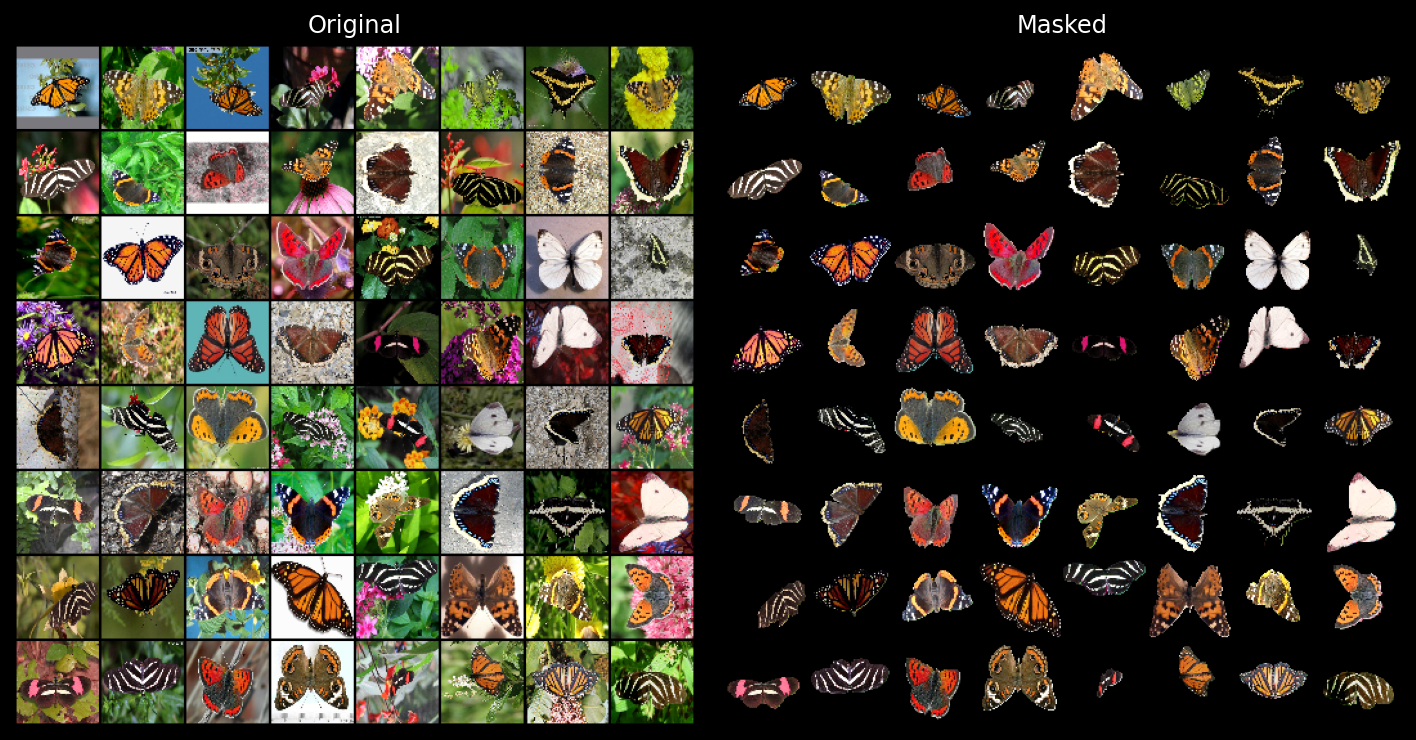

In [8]:
images, masks = next(iter(train_loader))

fig, ax = plt.subplots(1, 2, figsize=(10,6))

ax[0].imshow(make_grid(denormalize(images)[:64], nrow=8, padding=2).permute(1,2,0).numpy())
ax[0].set_axis_off()
ax[0].set_title("Original")

ax[1].imshow(make_grid((denormalize(images)*masks)[:64], nrow=8, padding=2).permute(1,2,0).numpy())
ax[1].set_axis_off()
ax[1].set_title("Masked")

plt.tight_layout()
plt.show()

## Model

In [22]:
#@title Model {vertical-output: true}

def _upsample_like(x, size):
    return F.interpolate(x, size=size, mode="bilinear", align_corners=False)


def _size_map(x, height):
    size = list(x.shape[-2:])
    sizes = {}
    for h in range(1, height):
        sizes[h] = size
        size = [math.ceil(w / 2) for w in size]
    return sizes


class ConvBNReLU(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dilate=1):
        super(ConvBNReLU, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1 * dilate, dilation=1 * dilate),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.main(x)


class RSU(nn.Module):
    def __init__(self, name, height, in_ch, mid_ch, out_ch, dilated=False):
        super(RSU, self).__init__()
        self.name = name
        self.height = height
        self.dilated = dilated
        self._make_layers(height, in_ch, mid_ch, out_ch, dilated)

    def forward(self, x):
        sizes = _size_map(x, self.height)
        x = self.rebnconvin(x)

        def unet(x, height=1):
            if height < self.height:
                x1 = getattr(self, f'rebnconv{height}')(x)
                if not self.dilated and height < self.height - 1:
                    x2 = unet(getattr(self, 'downsample')(x1), height + 1)
                else:
                    x2 = unet(x1, height + 1)

                x = getattr(self, f'rebnconv{height}d')(torch.cat((x2, x1), 1))
                return _upsample_like(x, sizes[height - 1]) if not self.dilated and height > 1 else x
            else:
                return getattr(self, f'rebnconv{height}')(x)

        return x + unet(x)

    def _make_layers(self, height, in_ch, mid_ch, out_ch, dilated=False):
        self.add_module('rebnconvin', ConvBNReLU(in_ch, out_ch))
        self.add_module('downsample', nn.MaxPool2d(2, stride=2, ceil_mode=True))

        self.add_module(f'rebnconv1', ConvBNReLU(out_ch, mid_ch))
        self.add_module(f'rebnconv1d', ConvBNReLU(mid_ch * 2, out_ch))

        for i in range(2, height):
            dilate = 1 if not dilated else 2 ** (i - 1)
            self.add_module(f'rebnconv{i}', ConvBNReLU(mid_ch, mid_ch, dilate=dilate))
            self.add_module(f'rebnconv{i}d', ConvBNReLU(mid_ch * 2, mid_ch, dilate=dilate))

        dilate = 2 if not dilated else 2 ** (height - 1)
        self.add_module(f'rebnconv{height}', ConvBNReLU(mid_ch, mid_ch, dilate=dilate))


class U2NET(nn.Module):
    def __init__(self, cfgs, out_ch=1):
        super(U2NET, self).__init__()
        self.out_ch = out_ch
        self._make_layers(cfgs)

    def forward(self, x):
        sizes = _size_map(x, self.height)
        maps = []

        def unet(x, height=1):
            if height < 6:
                x1 = getattr(self, f'stage{height}')(x)
                x2 = unet(getattr(self, 'downsample')(x1), height + 1)
                x = getattr(self, f'stage{height}d')(torch.cat((x2, x1), 1))
                side(x, height)
                return _upsample_like(x, sizes[height - 1]) if height > 1 else x
            else:
                x = getattr(self, f'stage{height}')(x)
                side(x, height)
                return _upsample_like(x, sizes[height - 1])

        def side(x, h):
            x = getattr(self, f'side{h}')(x)
            x = _upsample_like(x, sizes[1])
            maps.append(x)

        unet(x)
        
        # fuse saliency probability maps
        maps.reverse()
        x = torch.cat(maps, 1)
        x = getattr(self, 'outconv')(x)
        maps.insert(0, x)
        return [torch.sigmoid(x) for x in maps]

    def _make_layers(self, cfgs):
        self.height = int((len(cfgs) + 1) / 2)
        self.add_module('downsample', nn.MaxPool2d(2, stride=2, ceil_mode=True))
        for k, v in cfgs.items():
            # build rsu block
            self.add_module(k, RSU(v[0], *v[1]))
            if v[2] > 0:
                # build side layer
                self.add_module(f'side{v[0][-1]}', nn.Conv2d(v[2], self.out_ch, 3, padding=1))
        # build fuse layer
        self.add_module('outconv', nn.Conv2d(int(self.height * self.out_ch), self.out_ch, 1))

# cfgs for building RSUs and sides
# {stage : [name, (height(L), in_ch, mid_ch, out_ch, dilated), side]}
configs = {
    "lite": {
        'stage1': ['En_1', (7, 3, 16, 64), -1],
        'stage2': ['En_2', (6, 64, 16, 64), -1],
        'stage3': ['En_3', (5, 64, 16, 64), -1],
        'stage4': ['En_4', (4, 64, 16, 64), -1],
        'stage5': ['En_5', (4, 64, 16, 64, True), -1],
        'stage6': ['En_6', (4, 64, 16, 64, True), 64],
        'stage5d': ['De_5', (4, 128, 16, 64, True), 64],
        'stage4d': ['De_4', (4, 128, 16, 64), 64],
        'stage3d': ['De_3', (5, 128, 16, 64), 64],
        'stage2d': ['De_2', (6, 128, 16, 64), 64],
        'stage1d': ['De_1', (7, 128, 16, 64), 64],
    },
    "full": {
        'stage1': ['En_1', (7, 3, 32, 64), -1],
        'stage2': ['En_2', (6, 64, 32, 128), -1],
        'stage3': ['En_3', (5, 128, 64, 256), -1],
        'stage4': ['En_4', (4, 256, 128, 512), -1],
        'stage5': ['En_5', (4, 512, 256, 512, True), -1],
        'stage6': ['En_6', (4, 512, 256, 512, True), 512],
        'stage5d': ['De_5', (4, 1024, 256, 512, True), 512],
        'stage4d': ['De_4', (4, 1024, 128, 256), 256],
        'stage3d': ['De_3', (5, 512, 64, 128), 128],
        'stage2d': ['De_2', (6, 256, 32, 64), 64],
        'stage1d': ['De_1', (7, 128, 16, 64), 64],
    }
}

net = U2NET(configs["lite"], 1).to(device)
summary(net,(1,3,image_size,image_size),verbose=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─RSU: 1-1                               [1, 64, 64, 64]           --
|    └─ConvBNReLU: 2-1                   [1, 64, 64, 64]           --
|    |    └─Sequential: 3-1              [1, 64, 64, 64]           1,920
|    └─ConvBNReLU: 2-2                   [1, 16, 64, 64]           --
|    |    └─Sequential: 3-2              [1, 16, 64, 64]           9,264
|    └─MaxPool2d: 2-3                    [1, 16, 32, 32]           --
|    └─ConvBNReLU: 2-4                   [1, 16, 32, 32]           --
|    |    └─Sequential: 3-3              [1, 16, 32, 32]           2,352
|    └─MaxPool2d: 2-5                    [1, 16, 16, 16]           --
|    └─ConvBNReLU: 2-6                   [1, 16, 16, 16]           --
|    |    └─Sequential: 3-4              [1, 16, 16, 16]           2,352
|    └─MaxPool2d: 2-7                    [1, 16, 8, 8]             --
|    └─ConvBNReLU: 2-8                   [1, 16, 8, 8]             --
|  

## Training

In [10]:
def iou_score(pred, target, eps=1e-6):
    output_ = pred > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum(dim=(1,2,3))
    union = (output_ | target_).sum(dim=(1,2,3))
    return (intersection + eps) / (union + eps)


def dice_coef(pred, target, eps=1e-6):
    inter = (pred * target).sum(dim=(1,2,3))
    return (2. * inter + eps) / ((pred + target).sum(dim=(1,2,3)) + eps)


def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v):
	loss0 = F.binary_cross_entropy(d0, labels_v)
	loss1 = F.binary_cross_entropy(d1, labels_v)
	loss2 = F.binary_cross_entropy(d2, labels_v)
	loss3 = F.binary_cross_entropy(d3, labels_v)
	loss4 = F.binary_cross_entropy(d4, labels_v)
	loss5 = F.binary_cross_entropy(d5, labels_v)
	loss6 = F.binary_cross_entropy(d6, labels_v)

	loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
	return loss0, loss


def plot_metrics(metrics):
    fig = plt.figure(figsize=(10,4))

    for k, v in metrics.items():
        plt.plot(v, '-', alpha=0.8, label=k)

    plt.legend()
    plt.title('Metrics')
    plt.tight_layout()
    plt.show()


def plot_results(pred, target):
    fig, ax = plt.subplots(1, 2, figsize=(10,6))

    ax[0].imshow(make_grid(pred, nrow=8, padding=2).permute(1,2,0).numpy().clip(0,1))
    ax[0].set_axis_off()
    ax[0].set_title("Predicted")

    ax[1].imshow(make_grid(target, nrow=8, padding=2).permute(1,2,0).numpy().clip(0,1))
    ax[1].set_axis_off()
    ax[1].set_title("Target")

    plt.tight_layout()
    plt.show()

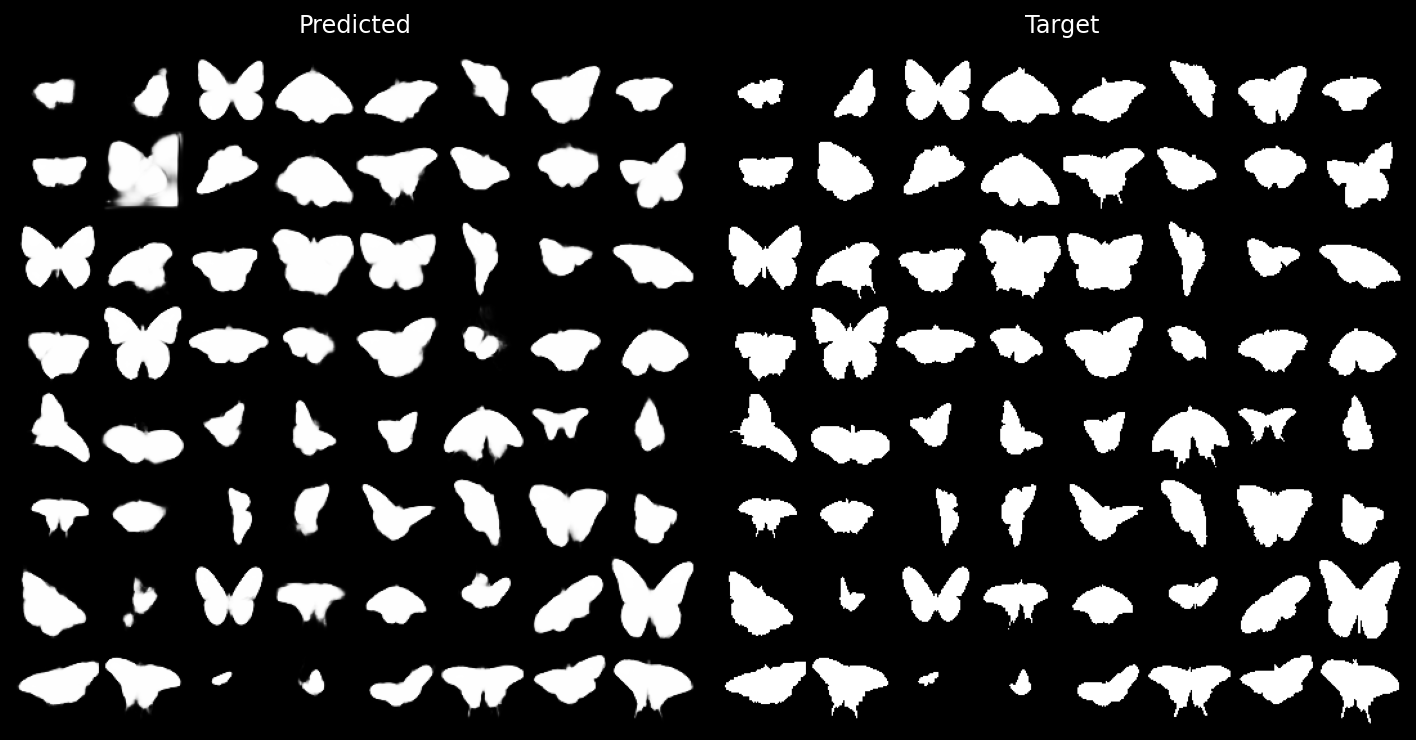

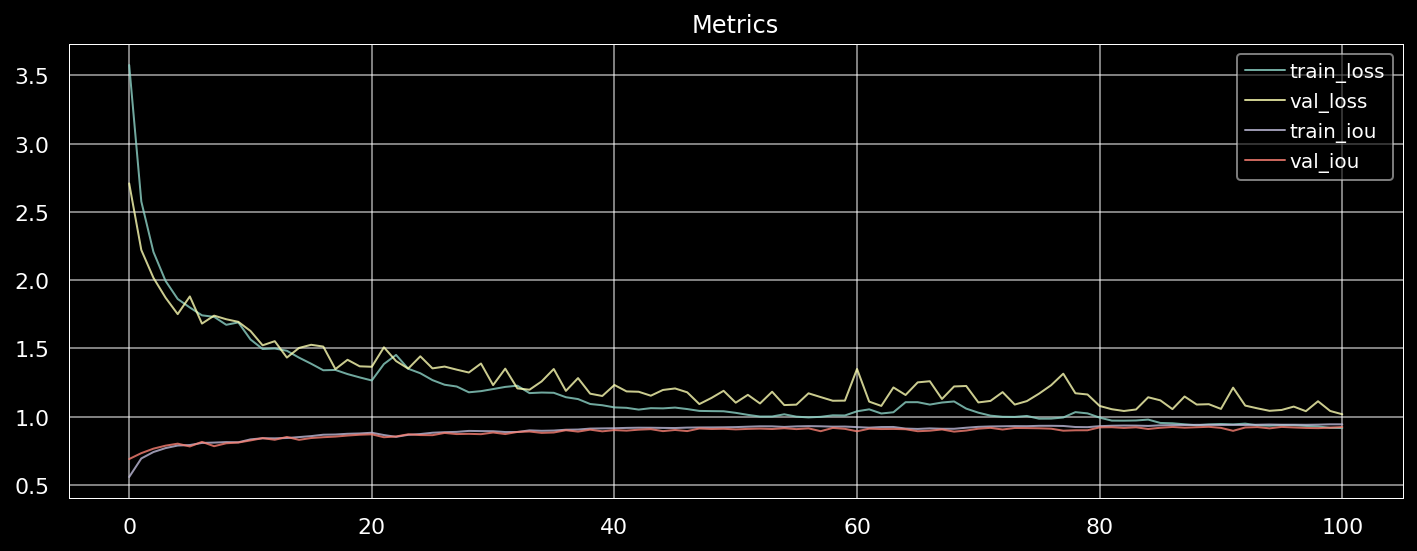

[100/101] elapsed: 2349s train_loss: 0.9163 val_loss: 1.0173 train_iou: 0.9437 val_iou: 0.9241 lr: 0.0010

In [23]:
#@title Train Loop {vertical-output: true}

epochs = 101

start = time.time()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

metrics = {"train_loss": [], "val_loss": [], "train_iou": [], "val_iou": []}

for epoch in range(epochs):
    train_loss = 0.0
    train_iou = 0.0
    
    for images, masks in train_loader:
        masks = masks.to(device)

        d0, d1, d2, d3, d4, d5, d6 = net(images.to(device))
        loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, masks)

        dice = dice_coef(d0, masks)
        loss += (1. - dice).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().cpu().item()
        train_iou += iou_score(d0, masks).mean()
        
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            masks = masks.to(device)
    
            d0, d1, d2, d3, d4, d5, d6 = net(images.to(device))
            loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, masks)

            dice = dice_coef(d0, masks)
            loss += (1. - dice).mean()

            val_loss += loss.detach().cpu().item()
            val_iou += iou_score(d0, masks).mean()
    
    metrics["train_loss"].append(train_loss / len(train_loader))
    metrics["val_loss"].append(val_loss / len(val_loader))
    metrics["train_iou"].append(train_iou / len(train_loader))
    metrics["val_iou"].append(val_iou / len(val_loader))

    if epoch % 5 == 0:
        clear_output(True)

        with torch.no_grad():
            images, masks = next(iter(val_loader))
            d0 = net(images.to(device))[0].detach().cpu()
            plot_results(d0, masks)

        plot_metrics(metrics)

    print("\r[{}/{}] elapsed: {}s train_loss: {:.4f} val_loss: {:.4f} train_iou: {:.4f} val_iou: {:.4f} lr: {:.4f}".format(
        epoch, epochs,
        int(time.time() - start),
        metrics["train_loss"][-1], metrics["val_loss"][-1],
        metrics["train_iou"][-1], metrics["val_iou"][-1],
        optimizer.param_groups[0]['lr']), 
        end="")

## Results

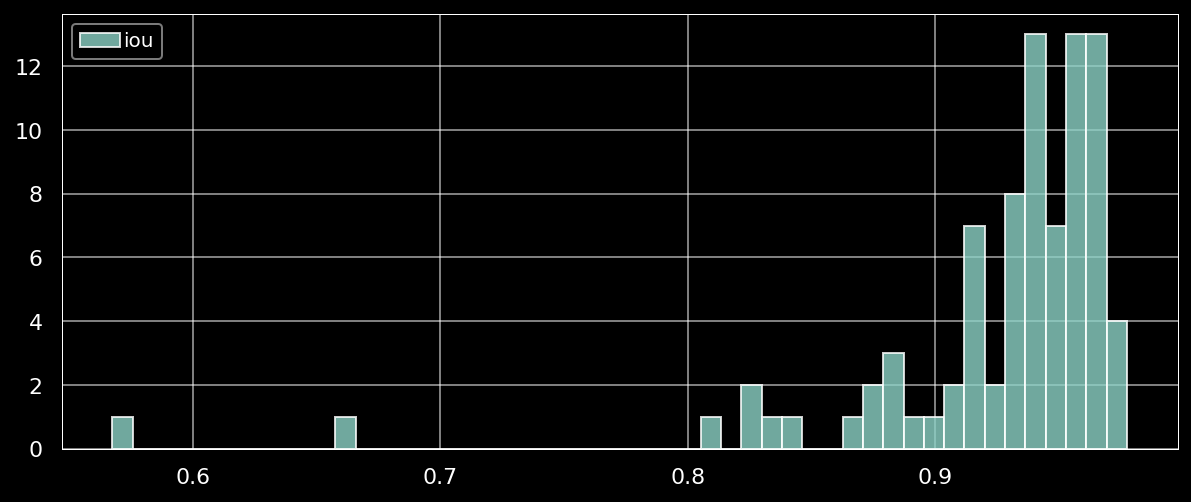

In [24]:
images, masks = [], []
for imgs, msks in val_loader:
    images.append(imgs)
    masks.append(msks)
images = torch.cat(images)
masks = torch.cat(masks)

with torch.no_grad():
    output = net(images.to(device))[0].detach().cpu()
    iou = iou_score(output, masks)

indices = iou.argsort(descending=True)

plt.figure(figsize=(10, 4))
plt.hist(iou, bins=50, alpha=0.8, label="iou")
plt.legend()
plt.show()

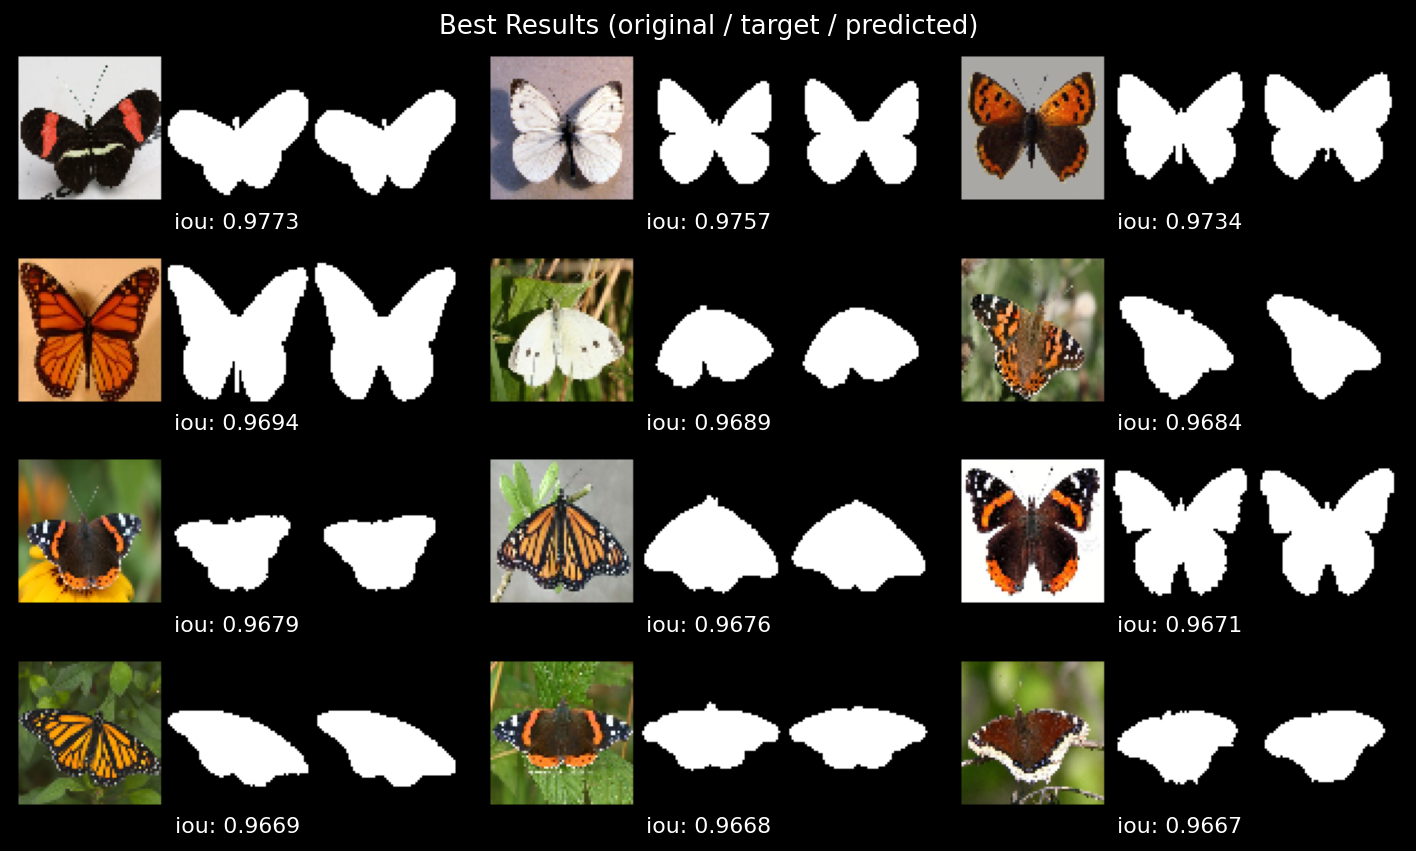

In [25]:
fig = plt.figure(figsize=(10, 6))

for i in range(12):
    idx = indices[i]
    img = torch.stack([denormalize(images[idx]), masks[idx].expand(3,-1,-1), output[idx].expand(3,-1,-1) > 0.5])
    ax = fig.add_subplot(4, 3, i + 1)
    ax.imshow(make_grid(img).permute(1,2,0).numpy().clip(0,1))
    ax.set(xlabel="iou: {:.4f}".format(iou[idx].item()),xticks=[],yticks=[])
    sns.despine(left=True,bottom=True)

fig.suptitle("Best Results (original / target / predicted)")
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()

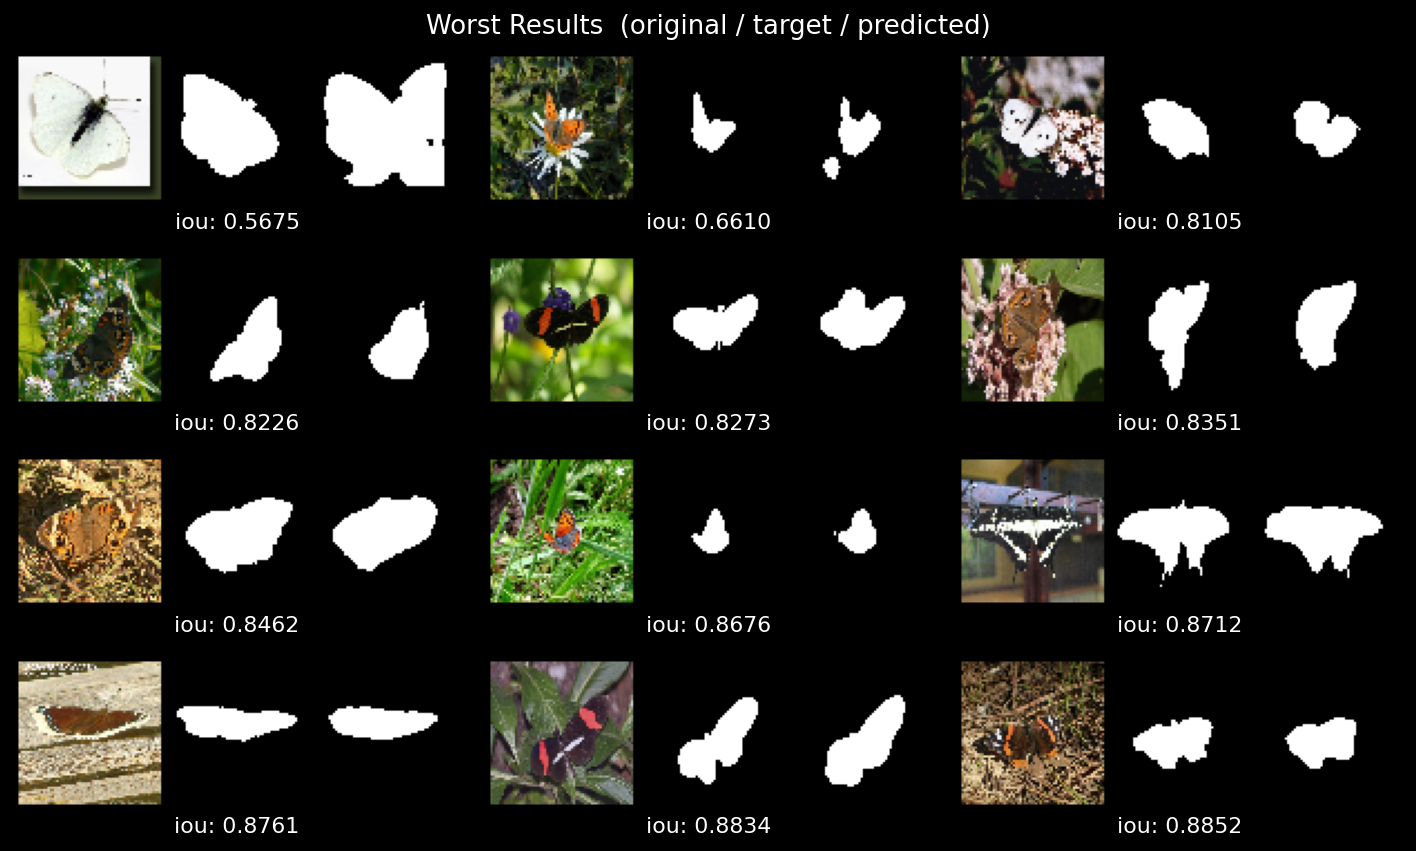

In [26]:
fig = plt.figure(figsize=(10, 6))

for i in range(12):
    idx = indices[-i-1]
    img = torch.stack([denormalize(images[idx]), masks[idx].expand(3,-1,-1), output[idx].expand(3,-1,-1) > 0.5])
    ax = fig.add_subplot(4, 3, i + 1)
    ax.imshow(make_grid(img).permute(1,2,0).numpy().clip(0,1))
    ax.set(xlabel="iou: {:.4f}".format(iou[idx].item()),xticks=[],yticks=[])
    sns.despine(left=True,bottom=True)

fig.suptitle("Worst Results  (original / target / predicted)")
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()